# Final Project Results and Metrics

In [36]:
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import numpy as np
import ast
#import the models
import baseline
import nn_with_rules
import base_nn



random.seed(0) # set a seed for reproducibility

### Run Models or Load in from output


In [37]:
baseline_output = "output/baseline_test.csv"
base_nn_output = "output/base_nn_test.csv"
nn_with_rules_output = "output/nn_with_rules_test_2.csv"

num_iters = 20 # number of times to run the baseline model if not loading it in

#get baseline (just rules based results)
if os.path.exists(baseline_output):
    baseline_df = pd.read_csv(baseline_output)
else:
    baseline_df= baseline.run_baseline(num_iters)
#get base_nn results
if os.path.exists(base_nn_output):
    base_nn_df = pd.read_csv(base_nn_output)
else:
    base_nn_df = base_nn.run_base_nn()
#get nn_with_rules results
if os.path.exists(nn_with_rules_output):
    nn_with_rules_df = pd.read_csv(nn_with_rules_output)
else:
    nn_with_rules_df = nn_with_rules.run_nn_with_rules()

baseline_df['y_pred'] = baseline_df['y_pred'].apply(ast.literal_eval)#this is a list of the output over x num of runs so treat it like a list
 

### Make sure that the results dfs are comparable

In [38]:
print(baseline_df.shape) # TODO: figure out why they aren't the same size, doing a different preprocessing approach for this
print(base_nn_df.shape)
print(nn_with_rules_df.shape)

print(baseline_df.columns)

(65, 21)
(65, 21)
(65, 21)
Index(['Unnamed: 0.2', 'Unnamed: 0', 'file', 'sent_i', 'sent', 'ne_info',
       'amr_graph', 'amr_head_name', 'amr_tail_name', 'amr_role',
       'umr_head_name', 'umr_tail_name', 'umr_role', 'amr_head_id',
       'umr_head_id', 'amr_tail_id', 'umr_tail_id', 'Unnamed: 0.1', 'y_guess',
       'y_guess_dist', 'y_pred'],
      dtype='object')


In [39]:
print("BASELINE (20x iterations)")
print(baseline_df["y_pred"][0:5])

print("BASE NN")
print(base_nn_df["y_pred"][0:5])

print("NN with RULES")
print(nn_with_rules_df["y_pred"][0:5])


BASELINE (20x iterations)
0    [:condition, :condition, :condition, :conditio...
1    [:mod, :mod, :mod, :mod, :mod, :mod, :mod, :mo...
2    [:mod, :mod, :mod, :mod, :mod, :mod, :mod, :mo...
3    [:mod, :mod, :mod, :mod, :mod, :mod, :mod, :mo...
4    [:mod, :mod, :mod, :mod, :mod, :mod, :mod, :mo...
Name: y_pred, dtype: object
BASE NN
0    :condition
1          :mod
2          :mod
3          :mod
4          :mod
Name: y_pred, dtype: object
NN with RULES
0    :condition
1          :mod
2          :mod
3          :mod
4          :mod
Name: y_pred, dtype: object


In [40]:
def get_accuracy(df):
    # Extract values from DataFrame columns
    y_true = df['umr_role'].values
    y_preds_list = df['y_pred'].values

    # Calculate accuracy

    if type(y_preds_list[0]) == list:
        y_preds_transposed = list(map(list, zip(*y_preds_list)))
        
        # Compute accuracy for each set of predictions
        accuracies = [accuracy_score(y_true, y_preds) for y_preds in y_preds_transposed]
        

        # Compute average accuracy
        accuracy = np.mean(accuracies) 
    else:
        accuracy = accuracy_score(y_true, y_preds_list)
        print(confusion_matrix(y_preds_list,y_true))
    return accuracy

total_acc = {"baseline": get_accuracy(baseline_df),
             "base_nn": get_accuracy(base_nn_df),
             "nn with rules": get_accuracy(nn_with_rules_df)}

print(total_acc)

[[ 1  0  0  0  0  0  0  4  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 46  3  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  6]]
[[ 1  0  0  0  0  0  0  4  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 46  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  1  0]]
{'baseline': 0.8284615384615386, 'base_nn': 0.8769230769230769, 'nn with rules': 0.8615384615384616}


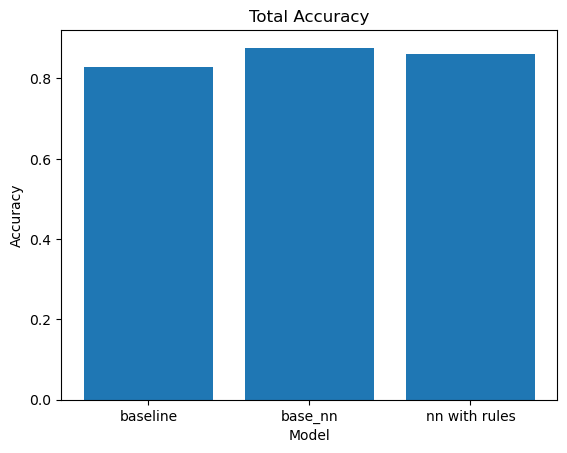

In [41]:
def plot_dict(data, title):
    # Extract x and y values from the dictionary
    x_values = list(data.keys())
    y_values = list(data.values())

    # Plotting
    plt.bar(x_values, y_values)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

plot_dict(total_acc, "Total Accuracy")


In [42]:
def get_per_class_f1(df):
    y_true = df["umr_role"]
    y_pred = df["y_pred"]

    if type(y_pred[0]) == list: #baseline with 20 runs, get the average per class f1
        y_preds_transposed = list(map(list, zip(*y_pred)))
        
        f1_dicts = {}
        for i in range(len(y_preds_transposed)):
            report = classification_report(y_true, y_preds_transposed[i], output_dict = True,zero_division=0.0)
            
            class_labels = [label for label in report.keys()]
            f1_scores = []
            for label in class_labels:
                if label[0] == ":":
                    f1_scores.append(report[label]['f1-score'])
            f1_dict = dict(zip(class_labels, f1_scores))
            f1_dicts[i] = f1_dict

        #make sure they all have the same keys:
            # Find the union of all keys in the interior dictionaries
        all_keys = set().union(*f1_dicts.values())

        # Update each interior dictionary with missing keys, assigning them a value of 0
        for entry in f1_dicts.values():
            for key in all_keys:
                entry.setdefault(key, 0)
        
        averages_dict = {}
        # Iterate over the keys ('cause' and 'reason')
        for key in f1_dicts[0].keys():
            # Calculate the average for each key
            average_value = np.mean([entry[key] for entry in f1_dicts.values()])
            # Store the result in the averages_dict
            averages_dict[key] = average_value
        
        f1_dict = averages_dict
        
    else:
        report = classification_report(y_true, y_pred, output_dict = True,zero_division=0.0)
        print(classification_report(y_true, y_pred, zero_division=0.0))
        class_labels = [label for label in report.keys()]
        f1_scores = []
        for label in class_labels:
            if label[0] == ":":
                f1_scores.append(report[label]['f1-score'])
        
        f1_dict = dict(zip(class_labels, f1_scores))
    if ":start" not in f1_dict:
        f1_dict[":start"] = 0

    if ":Material-of" not in f1_dict:
        f1_dict[":Material-of"] = 0

    print(len(f1_dict.keys()), f1_dict.keys())
    return f1_dict
    

print(get_per_class_f1(base_nn_df))
print(get_per_class_f1(nn_with_rules_df))
print(get_per_class_f1(baseline_df))

    

              precision    recall  f1-score   support

      :cause       0.20      1.00      0.33         1
  :condition       1.00      1.00      1.00         1
       :goal       1.00      1.00      1.00         2
   :material       0.00      0.00      0.00         1
        :mod       0.92      1.00      0.96        46
 :other-role       0.00      0.00      0.00         3
       :part       1.00      1.00      1.00         1
     :reason       0.00      0.00      0.00         4
     :source       1.00      1.00      1.00         6

    accuracy                           0.88        65
   macro avg       0.57      0.67      0.59        65
weighted avg       0.81      0.88      0.84        65

11 dict_keys([':cause', ':condition', ':goal', ':material', ':mod', ':other-role', ':part', ':reason', ':source', ':start', ':Material-of'])
{':cause': 0.33333333333333337, ':condition': 1.0, ':goal': 1.0, ':material': 0.0, ':mod': 0.9583333333333334, ':other-role': 0.0, ':part': 1.0, ':reason'

              precision    recall  f1-score   support

      :cause       0.20      1.00      0.33         1
  :condition       1.00      1.00      1.00         1
       :goal       1.00      1.00      1.00         2
   :material       0.00      0.00      0.00         1
        :mod       0.92      1.00      0.96        46
 :other-role       0.00      0.00      0.00         3
       :part       1.00      1.00      1.00         1
     :reason       0.00      0.00      0.00         4
     :source       1.00      0.83      0.91         6
      :start       0.00      0.00      0.00         0

    accuracy                           0.86        65
   macro avg       0.51      0.58      0.52        65
weighted avg       0.81      0.86      0.83        65

11 dict_keys([':cause', ':condition', ':goal', ':material', ':mod', ':other-role', ':part', ':reason', ':source', ':start', ':Material-of'])
{':cause': 0.33333333333333337, ':condition': 1.0, ':goal': 1.0, ':material': 0.0, ':mod': 0.9583333

              precision    recall  f1-score   support

      :cause       0.20      1.00      0.33         1
  :condition       1.00      1.00      1.00         1
       :goal       1.00      1.00      1.00         2
   :material       0.00      0.00      0.00         1
        :mod       0.92      1.00      0.96        46
 :other-role       0.00      0.00      0.00         3
       :part       1.00      1.00      1.00         1
     :reason       0.00      0.00      0.00         4
     :source       1.00      1.00      1.00         6

    accuracy                           0.88        65
   macro avg       0.57      0.67      0.59        65
weighted avg       0.81      0.88      0.84        65

11 dict_keys([':cause', ':condition', ':goal', ':material', ':mod', ':other-role', ':part', ':reason', ':source', ':start', ':Material-of'])
              precision    recall  f1-score   support

      :cause       0.20      1.00      0.33         1
  :condition       1.00      1.00      1.00  

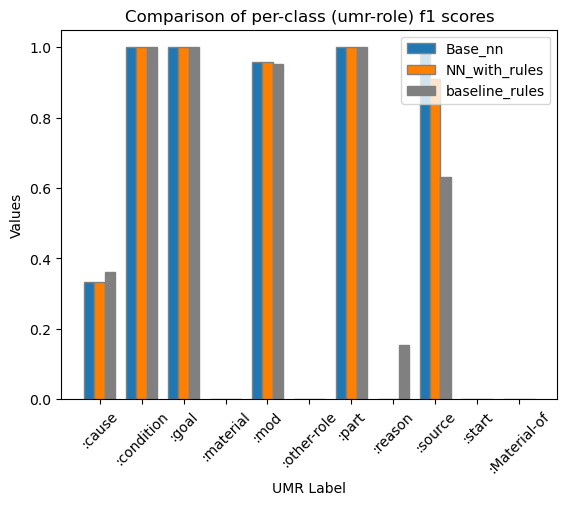

In [43]:
def plot_dicts(model1, model2, model3):


    # Extract keys and values
    keys = list(model1.keys())
    values_model1 = list(model1.values())
    values_model2 = list(model2.values())
    values_model3 = list(model3.values())

    # Set the width of the bars
    bar_width = 0.25

    # Set the positions for the bars on the x-axis
    r1 = range(len(keys))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    color_model1 = '#1f78b4'  # Blue
    color_model2 = '#ff7f00'  # Orange
    color_model3 = '#808080'  # Gray

    # Plotting
    plt.bar(r1, values_model1, color=color_model1, width=bar_width, edgecolor='grey', label='Base_nn')
    plt.bar(r2, values_model2, color=color_model2, width=bar_width, edgecolor='grey', label='NN_with_rules')
    plt.bar(r3, values_model3, color=color_model3, width=bar_width, edgecolor='grey', label='baseline_rules')

    # Add x-axis labels, y-axis label, and title
    plt.xlabel('UMR Label')
    plt.ylabel('Values')
    plt.title('Comparison of per-class (umr-role) f1 scores')
    plt.xticks([r + bar_width for r in range(len(keys))], keys, rotation = 45)

    # Add legend
    plt.legend()

    # Show the plot
    plt.show()

plot_dicts(get_per_class_f1(base_nn_df),get_per_class_f1(nn_with_rules_df),get_per_class_f1(baseline_df))
